# Find the Best Model


---

In [2]:
import joblib
from xgboost import XGBClassifier
from pprint import pprint
from glob import glob
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve, cross_val_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, ADASYN
import sklearn

import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from helpers import load_sqlite, custom_stop_words, get_random_class_labels, resample_data
from visualizer import Visualizer

In [4]:
def build_model(preprocessor, classifier, cv=3, scoring='roc_auc_ovr', verbose=1):
    '''
    Takes a dictionary with params and outputs a gridsearch model
    '''
    pipe = Pipeline(
    [('prep', preprocessor.get('preprocessor')),
     ('clf', classifier.get('estimator'))])
    
    pipe_params = dict()
    pipe_params.update(preprocessor.get('params'))
    pipe_params.update(classifier.get('params'))
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    model = GridSearchCV(pipe, param_grid=pipe_params, cv=skf, verbose=verbose, scoring=scoring, n_jobs=-1)
    return model

In [5]:
tfidf = {
    'preprocessor': TfidfVectorizer(stop_words=custom_stop_words),
    'name': 'TF-IDF Vectorizer',
    'params': {
        "prep__ngram_range": [(1, 2)],
        "prep__max_df": [.9],
        "prep__use_idf": [True],
        "prep__norm": ["l2"],
        # "prep__strip_accents": [None, 'ascii', 'unicode'],
        # "prep__ngram_range": [(1, 1), (1, 2)],
        # "prep__max_features": [5000, 6000, 7000],
        # "prep__min_df": np.arange(2, 20, 4),
        # "prep__max_df": np.linspace(.8, .99, 5),
        # "prep__norm": ("l1", "l2"),
        # "prep__use_idf": [True, False]
    }
}

In [6]:
estimators = {
    "logisticregression": {
        "name": "Logistic Regression",
        "estimator": LogisticRegression(max_iter=1000, fit_intercept=False, C=.99),
        "params": {
            "clf__solver": ["lbfgs", "saga"]
        }
    },
    "randomforestclassifier": {
        "name": "Random Forest",
        "estimator": RandomForestClassifier(min_samples_leaf=2, min_samples_split=.01),
        "params": {
            "clf__n_estimators": [300, 500, 1000],
            "clf__max_depth": np.linspace(400, 1000, 5, dtype=int)
        }
    },
    "multinomialnb": {
        "name": "Multinomial Bayes Classifier",
        "estimator": MultinomialNB(alpha=.1189),
        "params": {
            "clf__fit_prior": [True, False]
        }
    },
    "svc": {
        "name": "Support Vector Classifier",
        "estimator": SVC(kernel="sigmoid", probability=True),
        "params": {
            "clf__C": [.99, 1]
        }
    },
    "sgdclassifier": {
        "name": "Stochastic Gradient Descent Classifier",
        "estimator": SGDClassifier(alpha=.0001, fit_intercept=True, penalty="l2", loss="modified_huber"),
        "params":
            {
        }
    },
    'xgbclassifier': {
        'name': 'XGBoost Classifier',
        'estimator': XGBClassifier(n_estimators=200),
        'params': {
            "clf__max_depth": [3, 5, 10],
            # "clf__learning_rate": np.linspace(.001, .1, 3),
            # "clf__n_estimators": [50, 100, 200],
            # "clf__objective": ['binary:logistic', 'multi:softprob'],
            # "clf__booster": ['gbtree', 'gblinear', 'dart'],
            # "clf__gamma": np.linspace(0, 1, 3),
            # "clf__subsample": [.5, 1],
            # "clf__reg_lambda": np.linspace(0, 1, 3),
        }
    }
}

In [7]:
random_state = 77

labels = ['python','javascript','html']

df = load_sqlite(database='reddit.sqlite', class_labels=labels)

In [8]:
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

**************************************************
Model: Logistic Regression

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.5s finished



Train Score: 0.9916601685556087
Test Score: 0.8961928483752858
AUC Score: 0.8961928483752858

              precision    recall  f1-score   support

        html      0.734     0.594     0.656       320
  javascript      0.810     0.637     0.713       496
      python      0.801     0.912     0.853      1207

    accuracy                          0.794      2023
   macro avg      0.782     0.714     0.741      2023
weighted avg      0.793     0.794     0.788      2023



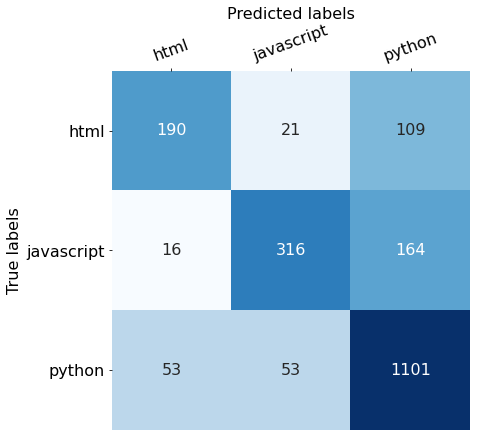



**************************************************
BEST MODEL SO FAR: Pipeline(steps=[('prep',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:   37.8s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:   46.5s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.9s finished



Train Score: 0.9658363494563154
Test Score: 0.874785782501736
AUC Score: 0.874785782501736

              precision    recall  f1-score   support

        html      0.629     0.547     0.585       320
  javascript      0.821     0.603     0.695       496
      python      0.782     0.895     0.835      1207

    accuracy                          0.768      2023
   macro avg      0.744     0.681     0.705      2023
weighted avg      0.768     0.768     0.761      2023



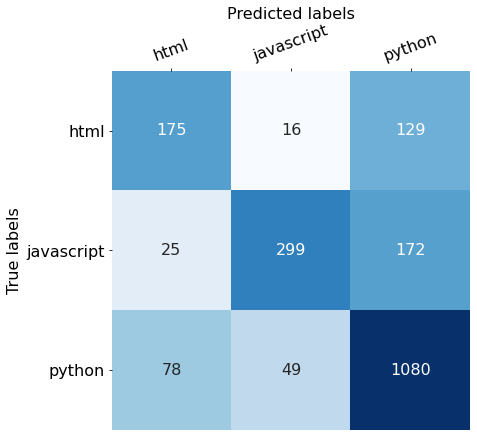



**************************************************
BEST MODEL SO FAR: Pipeline(steps=[('prep',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished



Train Score: 0.9992599685231335
Test Score: 0.9121318405608996
AUC Score: 0.9121318405608996

              precision    recall  f1-score   support

        html      0.649     0.747     0.695       320
  javascript      0.697     0.764     0.729       496
      python      0.868     0.799     0.832      1207

    accuracy                          0.782      2023
   macro avg      0.738     0.770     0.752      2023
weighted avg      0.791     0.782     0.785      2023



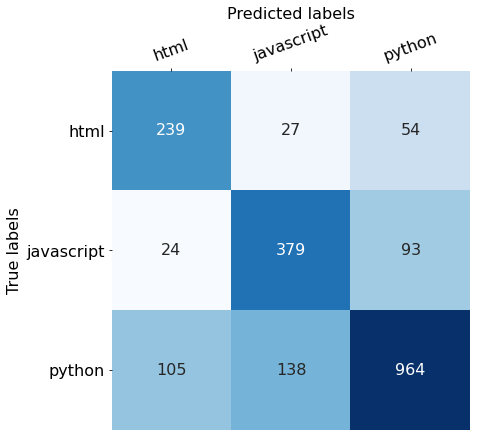



**************************************************
BEST MODEL SO FAR: Pipeline(steps=[('prep',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   10.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.1s finished



Train Score: 0.9919875465895921
Test Score: 0.9045249662147454
AUC Score: 0.9045249662147454

              precision    recall  f1-score   support

        html      0.776     0.553     0.646       320
  javascript      0.861     0.625     0.724       496
      python      0.794     0.944     0.863      1207

    accuracy                          0.804      2023
   macro avg      0.811     0.708     0.744      2023
weighted avg      0.808     0.804     0.795      2023



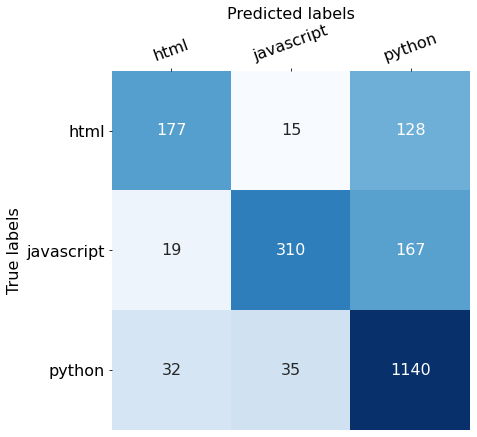



**************************************************
BEST MODEL SO FAR: Pipeline(steps=[('prep',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished



Train Score: 0.9993983909110633
Test Score: 0.9056204869343576
AUC Score: 0.9056204869343576

              precision    recall  f1-score   support

        html      0.713     0.644     0.677       320
  javascript      0.802     0.696     0.745       496
      python      0.831     0.897     0.863      1207

    accuracy                          0.808      2023
   macro avg      0.782     0.746     0.761      2023
weighted avg      0.805     0.808     0.804      2023



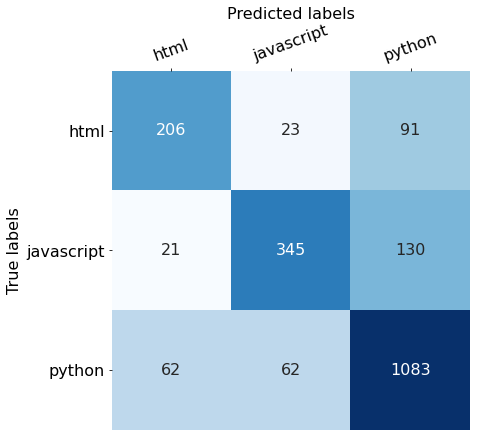



**************************************************
BEST MODEL SO FAR: Pipeline(steps=[('prep',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   10.2s remaining:   35.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   13.2s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   13.3s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   19.2s finished



Train Score: 0.9701254649141636
Test Score: 0.8735599212469122
AUC Score: 0.8735599212469122

              precision    recall  f1-score   support

        html      0.620     0.494     0.550       320
  javascript      0.877     0.532     0.662       496
      python      0.755     0.918     0.829      1207

    accuracy                          0.756      2023
   macro avg      0.751     0.648     0.680      2023
weighted avg      0.764     0.756     0.744      2023



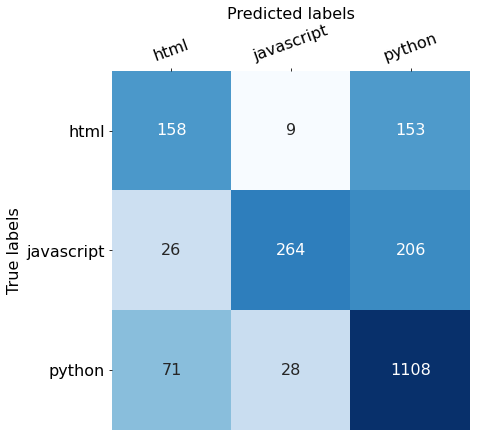



**************************************************
BEST MODEL SO FAR: Pipeline(steps=[('prep',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
  

In [9]:
fitted_models = dict()
best_auc_score = 0.0
best_model = None

for name, estimator in estimators.items():
    print("*"*50)
    print(f'Model: {estimator.get("name")}')
    print()
    model = build_model(preprocessor=tfidf, classifier=estimator, cv=5, verbose=0)
    model.fit(X_train, y_train)
    print()
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'Train Score: {train_score}')
    print(f'Test Score: {test_score}')
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
        print(f'AUC Score: {auc}')
    print()    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    viz = Visualizer(X=X_train, y=y_train, 
                    transformer=model.best_estimator_.named_steps.prep,
                    classifier=model.best_estimator_.named_steps.clf)
    
    viz.plot_confusion_matrix(y_test, y_pred)
    plt.show() # so it doesn't put them all at the end
    print()
    print()
    fitted_models[name] = {
        'auc_score': auc,
        'train_score': train_score,
        'test_score': test_score
    }
    if auc > best_auc_score:
        best_auc_score = auc
        best_model = model.best_estimator_
    
    print("*"*50)
    print('BEST MODEL SO FAR:', best_model)
    print()
    print()

In [10]:
model_output = pd.DataFrame(fitted_models).T
model_output

,auc_score,train_score,test_score
logisticregression,0.896193,0.991660,0.896193
randomforestclassifier,0.874786,0.965836,0.874786
multinomialnb,0.912132,0.999260,0.912132
svc,0.904525,0.991988,0.904525
sgdclassifier,0.905620,0.999398,0.905620
xgbclassifier,0.873560,0.970125,0.873560


In [11]:
best_model

Pipeline(steps=[('prep',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',

In [13]:
joblib.dump(best_model, '01_best_model')

['01_best_model']